# Wrangle ML datasets
- Explore tabular data for supervised machine learning
- Join relational data for supervised machine learning

# Explore tabular data for supervised machine learning 🍌

Wrangling your dataset is often the most challenging and time-consuming part of the modeling process.

In today's lesson, we’ll work with a dataset of [3 Million Instacart Orders, Open Sourced](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)!

Let’s get set up:

In [1]:
import pandas as pd
orders = pd.read_csv('/content/Instacart/orders.csv')
order_products_train = pd.read_csv('/content/Instacart/order_products__train.csv')
order_products_prior = pd.read_csv('/content/Instacart/order_products__prior.csv')
products = pd.read_csv('/content/Instacart/products.csv')
departments = pd.read_csv('/content/Instacart/departments.csv')
aisles = pd.read_csv('/content/Instacart/aisles.csv')

In [2]:
# For each csv file, look at its shape & head
orders.shape, order_products_train.shape, order_products_prior.shape, products.shape, departments.shape, aisles.shape

((2420091, 7), (1384617, 4), (4468501, 4), (49688, 4), (21, 2), (134, 2))

In [3]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1.0,2.0,8.0,NaN
1,2398795,1,prior,2.0,3.0,7.0,15.0
2,473747,1,prior,3.0,3.0,12.0,21.0
3,2254736,1,prior,4.0,4.0,7.0,29.0
4,431534,1,prior,5.0,4.0,15.0,28.0


In [4]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120.0,1.0,1.0
1,2,28985.0,2.0,1.0
2,2,9327.0,3.0,0.0
3,2,45918.0,4.0,1.0
4,2,30035.0,5.0,0.0


In [5]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [6]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [7]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [8]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


### The original task was complex ...

[The Kaggle competition said,](https://www.kaggle.com/c/instacart-market-basket-analysis/data):

> The dataset for this competition is a relational set of files describing customers' orders over time. The goal of the competition is to predict which products will be in a user's next order.

> orders.csv: This file tells to which set (prior, train, test) an order belongs. You are predicting reordered items only for the test set orders.

Each row in the submission is an order_id from the test set, followed by product_id(s) predicted to be reordered.

> sample_submission.csv:
```
order_id,products
17,39276 29259
34,39276 29259
137,39276 29259
182,39276 29259
257,39276 29259
```

### ... but we can simplify!

Simplify the question, from "Which products will be reordered?" (Multi-class, [multi-label](https://en.wikipedia.org/wiki/Multi-label_classification) classification) to **"Will customers reorder this one product?"** (Binary classification)

Which product? How about **the most frequently ordered product?**

### Questions:

- What is the most frequently ordered product?
- How often is this product included in a customer's next order?
- Which customers have ordered this product before?
- How can we get a subset of data, just for these customers?
- What features can we engineer? We want to predict, will these customers reorder this product on their next order?

## Follow Along

### What was the most frequently ordered product?

In [12]:
df = order_products_train.merge(products, on='product_id', how='left')

In [13]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,1,49302,1,1,Bulgarian Yogurt,120,16
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16
2,1,10246,3,0,Organic Celery Hearts,83,4
3,1,49683,4,0,Cucumber Kirby,83,4
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15


In [14]:
df.tail()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
1384612,3421063,14233,3,1,Natural Artesian Water,115,7
1384613,3421063,35548,4,1,Twice Baked Potatoes,13,20
1384614,3421070,35951,1,1,Organic Unsweetened Almond Milk,91,16
1384615,3421070,16953,2,1,Creamy Peanut Butter,88,13
1384616,3421070,4724,3,1,Broccoli Florettes,32,4


In [15]:
#most frequently ordered product
df['product_name'].value_counts().head(1)

Banana    18726
Name: product_name, dtype: int64

In [16]:
df.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
product_name         0
aisle_id             0
department_id        0
dtype: int64

### How often are bananas included in a customer's next order?

There are [three sets of data](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b):

> "prior": orders prior to that users most recent order (3.2m orders)  
"train": training data supplied to participants (131k orders)  
"test": test data reserved for machine learning competitions (75k orders)

Customers' next orders are in the "train" and "test" sets. (The "prior" set has the orders prior to the most recent orders.)

We can't use the "test" set here, because we don't have its labels (only Kaggle & Instacart have them), so we don't know what products were bought in the "test" set orders.

So, we'll use the "train" set. It currently has one row per product_id and multiple rows per order_id.

But we don't want that. Instead we want one row per order_id, with a binary column: "Did the order include bananas?"

Let's wrangle!

In [17]:
#how many times are bananas reordered
(df[(df['product_name'] == 'Banana') & (df['reordered'] > 0)]).shape[0]

16557

# Join relational data for supervised machine learning

## Overview
Often, you’ll need to join data from multiple relational tables before you’re ready to fit your models.

### Which customers have ordered this product before?

- Customers are identified by `user_id`
- Products are identified by `product_id`

Do we have a table with both these id's? (If not, how can we combine this information?)

In [18]:
df_user = df.merge(orders, on='order_id')

In [19]:
df_user.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,Bulgarian Yogurt,120,16,112108,train,4.0,4.0,10.0,9.0
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,112108,train,4.0,4.0,10.0,9.0
2,1,10246,3,0,Organic Celery Hearts,83,4,112108,train,4.0,4.0,10.0,9.0
3,1,49683,4,0,Cucumber Kirby,83,4,112108,train,4.0,4.0,10.0,9.0
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,112108,train,4.0,4.0,10.0,9.0


In [20]:
#Which customers/users have ordered bananas before?
df_banana_orders = df_user[df_user['product_name'] == 'Banana']
df_banana_orders['user_id']

98        51011
119       77529
141       61911
178       16111
199       34221
          ...  
975554    38708
975591    43300
975627    44275
975794    72444
976093    15818
Name: user_id, Length: 13236, dtype: int64

In [21]:
df_banana_orders

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
98,226,24852,2,0,Banana,24,4,51011,train,4.0,0.0,12.0,30.0
119,473,24852,2,0,Banana,24,4,77529,train,7.0,6.0,10.0,8.0
141,878,24852,2,1,Banana,24,4,61911,train,9.0,2.0,13.0,30.0
178,1042,24852,1,1,Banana,24,4,16111,train,10.0,1.0,17.0,30.0
199,1139,24852,1,1,Banana,24,4,34221,train,4.0,5.0,7.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
975554,3419435,24852,4,1,Banana,24,4,38708,train,26.0,2.0,9.0,22.0
975591,3419531,24852,2,1,Banana,24,4,43300,train,32.0,2.0,15.0,6.0
975627,3419542,24852,6,0,Banana,24,4,44275,train,4.0,6.0,9.0,16.0
975794,3420088,24852,9,1,Banana,24,4,72444,train,14.0,1.0,8.0,5.0


## Follow Along

### How can we get a subset of data, just for these customers?

We want *all* the orders from customers who have *ever* bought bananas.

(And *none* of the orders from customers who have *never* bought bananas.)

In [ ]:
# we created above the subset of all customers/users that ordered bananas -> df_banana_orders
df_no_banana_orders= df_user[df_user['product_name'] != 'Banana']
df_no_banana_orders.shape[0]

202699

In [ ]:
df_no_banana_orders[df_no_banana_orders['product_name']=='Banana'].shape

(0, 13)

### What features can we engineer? We want to predict, will these customers reorder bananas on their next order?

In [33]:
y = df_banana_orders['reordered']
X = df_banana_orders.drop(columns=['reordered','product_name', 'eval_set'])

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((10588, 10), (2648, 10), (10588,), (2648,))

In [36]:
#Baseline
baseline_acc = y_train.value_counts(normalize=True).max()
baseline_acc

0.887608613524745

In [49]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(random_state=42, n_jobs=-1,n_estimators=50, max_depth=10)

model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=50, n_jobs=-1,
                       random_state=42)

In [50]:
model_rf.score(X_train, y_train)

0.8964865885908576

In [51]:
model_rf.score(X_val, y_val)

0.881797583081571

In [53]:
list(zip(X.columns, model_rf.feature_importances_))

[('order_id', 0.17568168264278552),
 ('product_id', 0.0),
 ('add_to_cart_order', 0.1788636586516678),
 ('aisle_id', 0.0),
 ('department_id', 0.0),
 ('user_id', 0.171323934910624),
 ('order_number', 0.19833389721680164),
 ('order_dow', 0.0646594930860323),
 ('order_hour_of_day', 0.10133789450635111),
 ('days_since_prior_order', 0.1097994389857375)]

Text(0.5, 0, 'Random Forest Feature Importance')

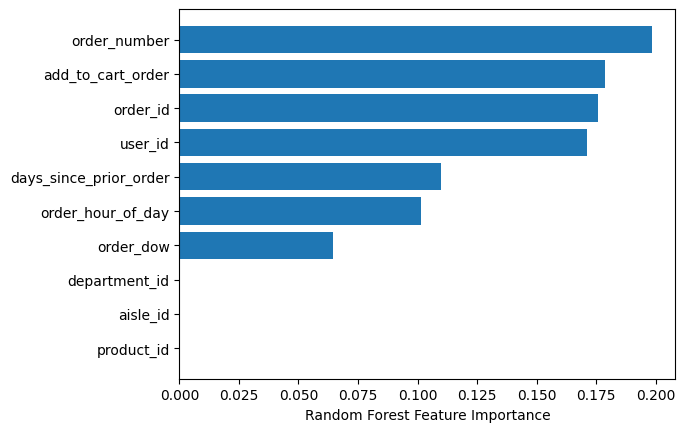

In [57]:
import matplotlib.pyplot as plt
sorted_idx = model_rf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], model_rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [58]:
#OK, lets drop product_id, aisle_id, and department_id
y = df_banana_orders['reordered']
X_2 = df_banana_orders.drop(columns=['reordered','product_name', 'eval_set', 'product_id', 'aisle_id', 'department_id'])

In [59]:
X2_train, X2_val, y2_train, y2_val = train_test_split(X_2, y, test_size=0.2, random_state=42)

In [60]:
X2_train.shape, X2_val.shape, y2_train.shape, y2_val.shape

((10588, 7), (2648, 7), (10588,), (2648,))

In [61]:
baseline_acc = y2_train.value_counts(normalize=True).max()
baseline_acc

0.887608613524745

In [65]:
model2 = RandomForestClassifier(random_state=42, n_jobs=-1,n_estimators=50, max_depth=10)

model2.fit(X2_train, y2_train)

RandomForestClassifier(max_depth=10, n_estimators=50, n_jobs=-1,
                       random_state=42)

In [66]:
model2.score(X2_train, y2_train)

0.8967699282206272

In [67]:
model2.score(X2_val, y2_val)

0.8814199395770392

In [68]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model2, X2_train, y2_train, cv=5)

In [69]:
scores

array([0.8871577 , 0.88668555, 0.88668555, 0.88852149, 0.88804913])

In [70]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.89 (+/- 0.00)


## Challenge

**Continue to clean and explore your data.** Can you **engineer features** to help predict your target? For the evaluation metric you chose, what score would you get just by guessing? Can you **make a fast, first model** that beats guessing?

We recommend that you use your portfolio project dataset for all assignments this sprint. But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset today. Follow the instructions in the assignment notebook. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!